# Fetch Horizon 3D bulk data from DSIS

This notebook demonstrates how to fetch and decode **HorizonData3D** binary (protobuf) data from DSIS using the `dsis-client` library.

The following steps are covered:

1. Authenticate to DSIS using an `.env` file with the required configuration and credentials.
2. Construct and execute a query requesting horizon metadata.
3. Fetch binary bulk data for a specific horizon using `get_bulk_data()` and `get_bulk_data_stream()`.
4. Decode the protobuf response and convert it to a NumPy array for analysis.

For more information about the required content of the `.env` file, please contact the SDD-SID team, or the DSIS team in Equinor.

In [23]:
from dotenv import load_dotenv
import os
import json

import numpy as np
from dsis_client import DSISClient, DSISConfig, QueryBuilder, Environment
from dsis_model_sdk.protobuf import decode_horizon_data
from dsis_model_sdk.utils.protobuf_decoders import horizon_to_numpy, horizon_samples_to_dict

### Authenticate and connect to DSIS

We need to specify the name of the model we plan to use, as the `dsis-client` library requires this when building the `DSISConfig` object.

In [24]:
MODEL_NAME = "OpenWorksCommonModel"

Next, we provide all the other required configuration and credentials via the `.env` file. Make sure to modify the `config` logic below if you are, e.g., fetching secrets from a key vault through this notebook.

In [25]:
load_dotenv(".env")

True

In [26]:
config = DSISConfig(
    environment=Environment.DEV,
    tenant_id=os.getenv("tenant_id"),
    client_id=os.getenv("client_id"),
    client_secret=os.getenv("client_secret"),
    access_app_id=os.getenv("resource_id"),
    dsis_username=os.getenv("dsis_function_key"),
    dsis_password=os.getenv("dsis_password"),
    subscription_key_dsauth=os.getenv("subscription_key_dsauth"),
    subscription_key_dsdata=os.getenv("subscription_key_dsdata"),
    dsis_site=os.getenv("dsis_site"),
)

In [27]:
dsis_client = DSISClient(config)
if dsis_client.test_connection():
    print("✓ Connected to DSIS API")

✓ Connected to DSIS API


### Build and execute a query

Specify the OW database (district) and project.

In [28]:
DISTRICT = "SV4VM"
PROJECT = "SNORRE_TORDIS_VIGDIS"

In [29]:
def build_district_id(database: str, *, model_name: str) -> str:
    """Build DSIS district_id from database name.

    DSIS uses different district-id conventions for different models.

    Examples:
    - OpenWorksCommonModel: OpenWorksCommonModel_OW_<DB>-OW_<DB>
    - OpenWorks native models (e.g., OW5000): OpenWorks_OW_<DB>_SingleSource-OW_<DB>
    """
    if model_name == "OpenWorksCommonModel":
        return f"OpenWorksCommonModel_OW_{database}-OW_{database}"
    return f"OpenWorks_OW_{database}_SingleSource-OW_{database}"

Build a query for `HorizonData3D` to list available horizons.

In [30]:
query = (
    QueryBuilder(
        model_name=MODEL_NAME,
        district_id=build_district_id(DISTRICT, model_name=MODEL_NAME),
        project=PROJECT,
    )
    .schema("HorizonData3D")
)

Execute the query and inspect the first horizon.

In [31]:
horizons = list(dsis_client.execute_query(query, max_pages=1))
print(f"Found {len(horizons)} horizons")

Found 1000 horizons


In [32]:
# Inspect the first horizon
horizon = horizons[0]
print(horizon)
print(horizon["native_uid"])

{'odata.mediaReadLink': "HorizonData3D('1000')/$value", 'odata.mediaEditLink': "HorizonData3D('1000')", 'odata.mediaContentType': 'application/octet-stream', 'data@odata.mediaEditLink': "HorizonData3D('1000')/data", 'data@odata.mediaReadLink': "HorizonData3D('1000')/data", 'data@odata.mediaContentType': 'application/octet-stream', 'interpretation_version_name': 'UPGRADE', 'name_state': 'DISABLED', 'horizon_attribute_name': 'TIME_STRUCTURE', 'horizon_max_trace': None, 'horizon_mean': '72.1147681124212', 'data_domain': 'TIME', 'name_of_data_repository': 'GRIDDED_HORIZON', 'create_date': '2009-11-09T23:20:20.000', 'create_user_id': 'R5000', 'native_uid': '1000', 'horizon_max_unit': 'ms', 'horizon_alias': None, 'data_source': 'LGC', 'data_unit': 'ms', 'update_date': '2010-02-10T15:29:56.000', 'horizon_max': '348.7724609375', 'line_color_g': 255, 'line_weight': 3, 'line_color_r': 0, 'original_create_date': '2009-05-19T10:13:34.000', 'line_color': None, 'datum': None, 'seis_pick_onset': 'Min

### Fetch bulk (binary) data

The `dsis-client` provides two methods for downloading binary protobuf data:

- **`get_bulk_data()`** – loads everything at once (best for < 100 MB)
- **`get_bulk_data_stream()`** – streams in chunks (best for > 100 MB)

Use `query.entity(native_uid)` to target a specific entity's binary data, then pass the query to the bulk-data method.

For `HorizonData3D` the default `data_field="data"` is used, so we don’t need to override it.

#### Method 1: `get_bulk_data()` — load everything at once

Best for small to medium datasets (< 100 MB). We target the entity with `query.entity()` and pass the resulting query to `get_bulk_data()`.

In [33]:
# Target the entity's binary data field via query.entity()
bulk_query = query.entity(horizon["native_uid"])

# Fetch all bulk data at once
binary_data = dsis_client.get_bulk_data(bulk_query)

if binary_data:
    print(f"Downloaded {len(binary_data):,} bytes")
else:
    print("No bulk data available for this horizon")

Downloaded 3,344,259 bytes


### Decode protobuf and convert to NumPy

The binary payload is a Protocol Buffer message prepended with a **varint length prefix**. We decode it with `decode_horizon_data(skip_length_prefix=True)` and then reshape it into a 2-D NumPy array with `horizon_to_numpy()`.

In [34]:
# Use skip_length_prefix=True — the DSIS API prepends a varint length prefix
decoded = decode_horizon_data(binary_data, skip_length_prefix=True)

mode_name = "FULL" if decoded.mode == decoded.FULL else "SAMPLES"
print(f"Mode           : {mode_name}")
print(f"Grid dimensions: {decoded.numberOfRows} x {decoded.numberOfColumns}")

array, metadata = horizon_to_numpy(decoded)

if array is not None:
    # FULL mode — we have a 2D grid
    print(f"Array shape   : {array.shape}")
    valid_data = array[~np.isnan(array)]
    print(f"Data coverage : {len(valid_data) / array.size * 100:.1f}%")
    if len(valid_data) > 0:
        print(f"Value range   : [{np.min(valid_data):.2f}, {np.max(valid_data):.2f}]")
        print(f"Mean ± Std    : {np.mean(valid_data):.2f} ± {np.std(valid_data):.2f}")
else:
    # SAMPLES mode — sparse data, no full grid
    samples = horizon_samples_to_dict(decoded)
    values = [s["value"] for s in samples]
    print(f"Sample count  : {len(samples):,}")
    print(f"Value range   : [{min(values):.2f}, {max(values):.2f}]")
    print(f"\nFirst 5 samples:")
    for s in samples[:5]:
        print(f"  col={s['column']}, row={s['row']}, z={s['value']:.2f}")

Mode           : SAMPLES
Grid dimensions: 1951 x 2411
Sample count  : 304,022
Value range   : [6.98, 348.77]

First 5 samples:
  col=561, row=917, z=54.92
  col=562, row=835, z=87.38
  col=562, row=836, z=101.56
  col=562, row=837, z=106.30
  col=562, row=838, z=112.12


### Quick visualisation

A simple `imshow` plot of the horizon depth surface.

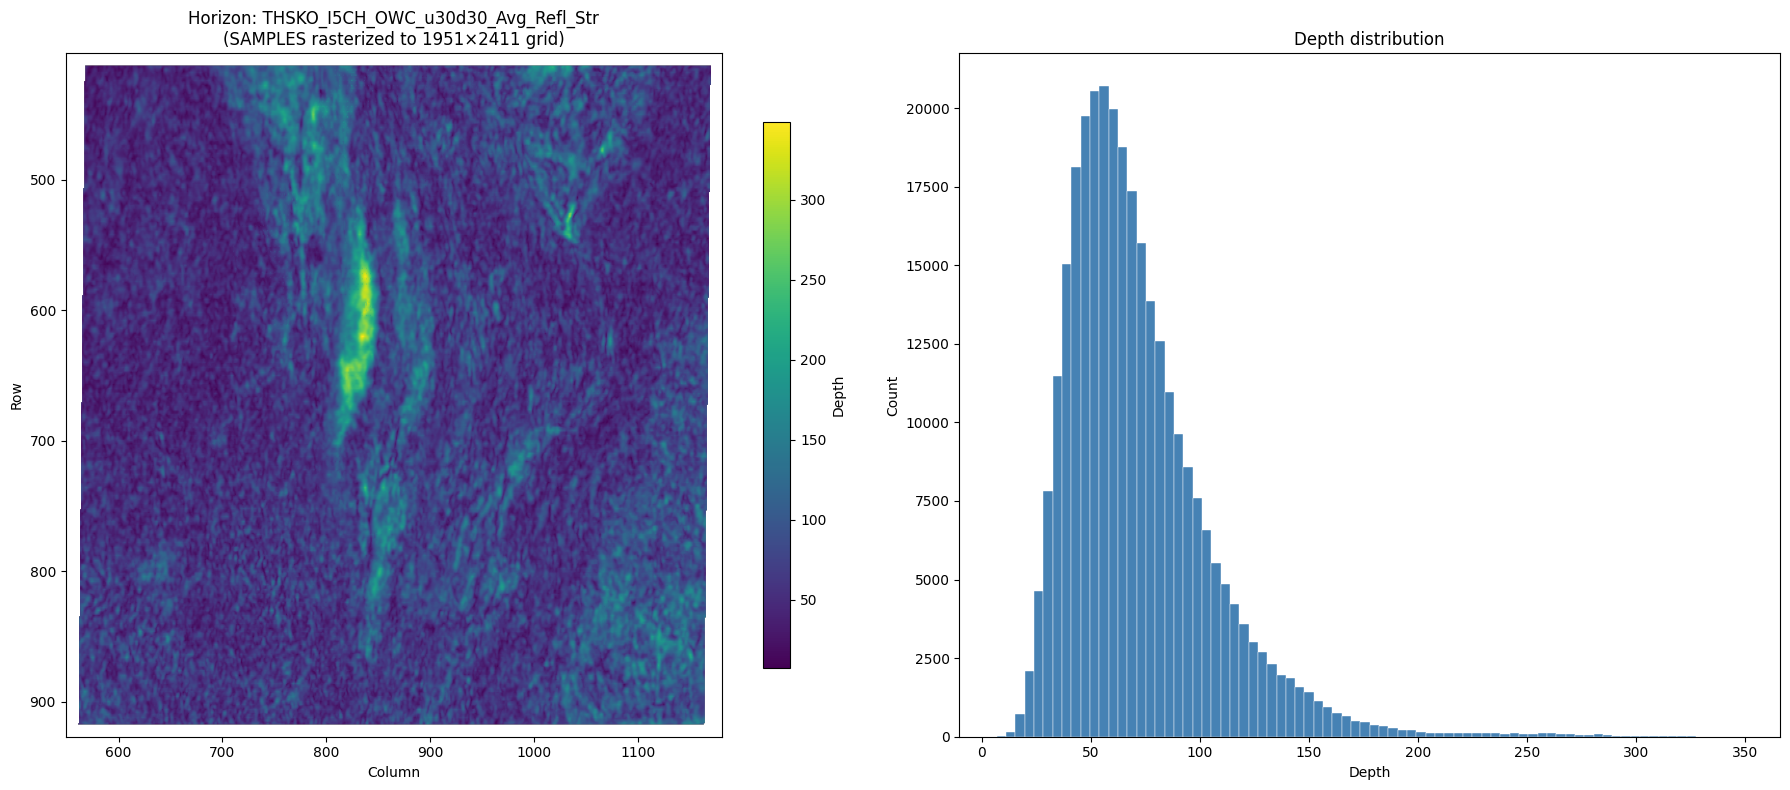

Coverage: 304,022 samples / 4,703,861 cells = 6.5%


In [36]:
import matplotlib.pyplot as plt

title = f"Horizon: {horizon.get('horizon_name', horizon.get('native_uid', 'unknown'))}"

if array is not None:
    # FULL mode — plot as 2D grid, cropped to data extent
    data_mask = ~np.isnan(array)
    data_rows, data_cols = np.where(data_mask)

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(array, cmap="viridis", aspect="auto")
    ax.set_title(title)
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")

    # Zoom to bounding box of non-NaN data
    if len(data_rows) > 0:
        pad_r = max(1, int((data_rows.max() - data_rows.min()) * 0.02))
        pad_c = max(1, int((data_cols.max() - data_cols.min()) * 0.02))
        ax.set_xlim(data_cols.min() - pad_c, data_cols.max() + pad_c)
        ax.set_ylim(data_rows.max() + pad_r, data_rows.min() - pad_r)  # inverted y for imshow

    fig.colorbar(im, ax=ax, label="Depth")
    plt.tight_layout()
    plt.show()
else:
    # SAMPLES mode — rasterize sparse samples into a 2D grid for imshow
    rows_idx = np.array([s["row"] for s in samples])
    cols_idx = np.array([s["column"] for s in samples])
    vals = np.array([s["value"] for s in samples], dtype=np.float32)

    n_rows = decoded.numberOfRows
    n_cols = decoded.numberOfColumns
    r0 = decoded.firstRowIndex
    c0 = decoded.firstColumnIndex

    grid = np.full((n_rows, n_cols), np.nan, dtype=np.float32)
    local_rows = rows_idx - r0
    local_cols = cols_idx - c0
    grid[local_rows, local_cols] = vals

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Left: rasterized grid, cropped to data extent
    im = axes[0].imshow(grid, cmap="viridis", aspect="auto")
    axes[0].set_title(f"{title}\n(SAMPLES rasterized to {n_rows}×{n_cols} grid)")
    axes[0].set_xlabel("Column")
    axes[0].set_ylabel("Row")

    # Zoom to bounding box of actual samples
    pad_r = max(1, int((local_rows.max() - local_rows.min()) * 0.02))
    pad_c = max(1, int((local_cols.max() - local_cols.min()) * 0.02))
    axes[0].set_xlim(local_cols.min() - pad_c, local_cols.max() + pad_c)
    axes[0].set_ylim(local_rows.max() + pad_r, local_rows.min() - pad_r)

    fig.colorbar(im, ax=axes[0], label="Depth", shrink=0.8)

    # Right: depth histogram
    axes[1].hist(vals, bins=80, color="steelblue", edgecolor="white", linewidth=0.3)
    axes[1].set_title("Depth distribution")
    axes[1].set_xlabel("Depth")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

    coverage = len(samples) / (n_rows * n_cols) * 100
    print(f"Coverage: {len(samples):,} samples / {n_rows * n_cols:,} cells = {coverage:.1f}%")

#### Method 2: `get_bulk_data_stream()` — stream in chunks

Best for large datasets (> 100 MB). Data is yielded in chunks so the full response never has to fit in memory at once.

In [22]:
# Stream bulk data in chunks (memory-efficient for large datasets)
chunks: list[bytes] = []
for chunk in dsis_client.get_bulk_data_stream(
    bulk_query,
    chunk_size=10 * 1024 * 1024,  # 10 MB per chunk (DSIS recommended)
):
    chunks.append(chunk)
    print(f"  Received chunk: {len(chunk):,} bytes")

if chunks:
    streamed_data = b"".join(chunks)
    print(f"\nTotal downloaded: {len(streamed_data):,} bytes")

    decoded_stream = decode_horizon_data(streamed_data, skip_length_prefix=True)
    array_stream, _ = horizon_to_numpy(decoded_stream)

    if array_stream is not None and array is not None:
        print(f"Grid shape: {array_stream.shape}")
        print(f"Arrays match: {np.array_equal(np.nan_to_num(array), np.nan_to_num(array_stream))}")
    else:
        samples_stream = horizon_samples_to_dict(decoded_stream)
        print(f"Samples count: {len(samples_stream)}")
        print(f"Matches non-streamed: {len(samples_stream) == len(samples)}")
else:
    print("No bulk data returned")

  Received chunk: 15,811 bytes
  Received chunk: 573 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 bytes
  Received chunk: 6 bytes
  Received chunk: 16,378 byte